# Goals for this analysis:
### Core goal: Practice web-scraping
### 1) Understand overall dialogue ditribution across the series by character
### 2) Understand how dialogue distribution evolves across episodes and seasons
### 3) Understand how many times Zuko says "honor" (and if anyone else says it more)

In [1]:
import requests, urllib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb, re
from bs4 import BeautifulSoup
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [4]:
def add_gaang(dictionary, nest_value = None):
    gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]
    if nest_value is not None:
        for character in gaang:
            dictionary[nest_value][character] = []
    else:
        for character in gaang:
            dictionary[character] = []

In [58]:
def clean_descriptors(html_soup, destination):
    for i in html_soup.body.find_all('b'):
        if i.text in gaang or i.text[:-1] in gaang:
            if i.text[-1] == ":" or i.text[-1] == " ":
                key = i.text[:-1]
            else:
                key = i.text


            x = []


            for j in i.next_siblings:
                if j.name == "b":
                    break
                #elif j.name == "i": Removes Italics; issues is emphasized words are italicized
                #    pass
                elif j.string == None:
                    pass
                elif j.name == 'i' and "(" in j.string: #(j.string[0] == "(" or j.string[1] == "("):
                    pass
                elif j.name == 'i' and ")" in j.string:
                    pass
                elif j.name == "i" and ")" in j.next_sibling.string:
                    pass
                elif j.string == "(" or j.string == " (":
                    pass
                else:
                    x.append(str(j)) ## here vs later loop for <i> vs  [] 
            destination[key].append(x)
            pass

## First thing's first: we need to compile our dataset. I found a great repository of ATLA transcripts at atla.avatarpsirit.net and used the beautiful soup library to import the count of lines per episode, using pandas to store and export the results into a dataframe.

In [3]:
atla_ep_data = []
episode_key = "101"
count = 1
gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]

while int(episode_key) < 400:
    season = episode_key[0]
    ep = episode_key[1:]
    ep_stats = {"Season": season, "Episode": ep}
    
    url = f"http://atla.avatarspirit.net/transcripts.php?num={episode_key}"
    #print(url)
    page = requests.get(url)
    page_soup = BeautifulSoup(page.content, 'html.parser')

    #if len(page_soup.find_all('title', string = "Error :: AvatarSpirit.net") ) > 0:
    if len(page_soup.find_all("div", {"class": "welcome"}, text = "Error")) > 0:
        episode_key = str(int(episode_key) + 101 - int(episode_key[1:]))
        pass
    else:
        for character in gaang:
            ep_stats[character] = len(page_soup.find_all('b', string = [character, character+":"]))
        atla_ep_data.append(ep_stats)
        episode_key = str(int(episode_key)+1)
        count += 1
            
print (f"Finished parsing all episodes. Total number counted: {count-1} / 61")
del count

Finished parsing all episodes. Total number counted: 61 / 61


In [5]:
df = pd.DataFrame(atla_ep_data)
df[df["Season"] == "3"]

,Season,Episode,Aang,Katara,Sokka,Suki,Toph,Zuko,Mai,Ty Lee,Azula,Iroh
40,3,01,37,30,18,0,10,11,2,0,10,0
41,3,02,53,14,18,0,8,10,3,0,5,0
42,3,03,24,27,28,0,9,0,0,0,0,0
43,3,04,22,20,41,0,13,0,0,0,0,0
44,3,05,4,2,1,0,4,39,22,26,37,0
45,3,06,16,4,3,0,3,9,0,0,3,4
46,3,07,18,50,31,0,58,0,0,0,0,0
47,3,08,20,35,35,0,15,0,0,0,0,0
48,3,09,58,26,22,0,10,17,9,0,5,0
49,3,10,22,18,26,0,7,2,0,0,0,4


# Goal 1: Overall Dialogue distribution

## dataset: check
## bargraph: locked and loaded

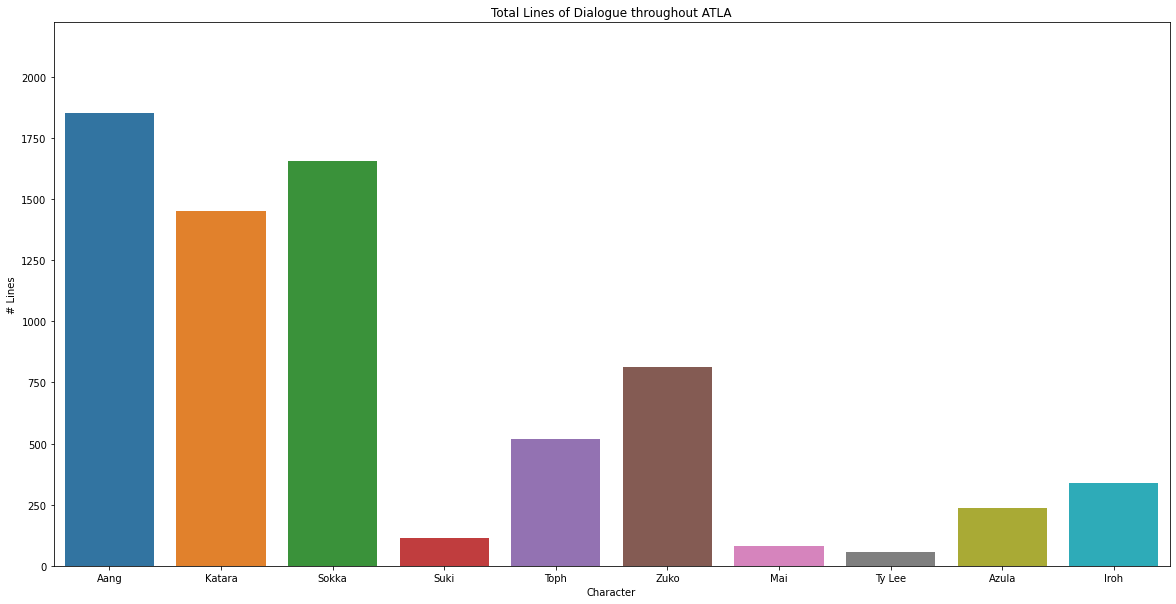

In [6]:
#df[gaang].sum().plot(kind='bar', figsize=(20,10))

plt.figure(figsize=(20,10))
# make barplot and sort bars
total_dialogue = sb.barplot(data = df[gaang], estimator = np.sum, errwidth = 0)
total_dialogue.set_title("Total Lines of Dialogue throughout ATLA")
total_dialogue.set_ylabel("# Lines")
total_dialogue.set_xlabel("Character");

# Goal 2: Dialogue evolution

## We've already got the dataset, but evolution of multiple elements over time is best shown with a multi-line plot. I originally tried to map the results for every character onto a single graph, but that proved...chaotic. I settled on mapping the Core 4 for the public analysis.

## A line plot is a line plot, but matplotlib provides multiple ways to display plots. I wanted all 3 seasons plotted in a single figure, so I used the subplot method. Now to decide if I want a 1x3 or a 3x1 grid...

#### Unfortunately, the horizontal 1,3 matrix isn't very legible given laptop screen size (see below)...

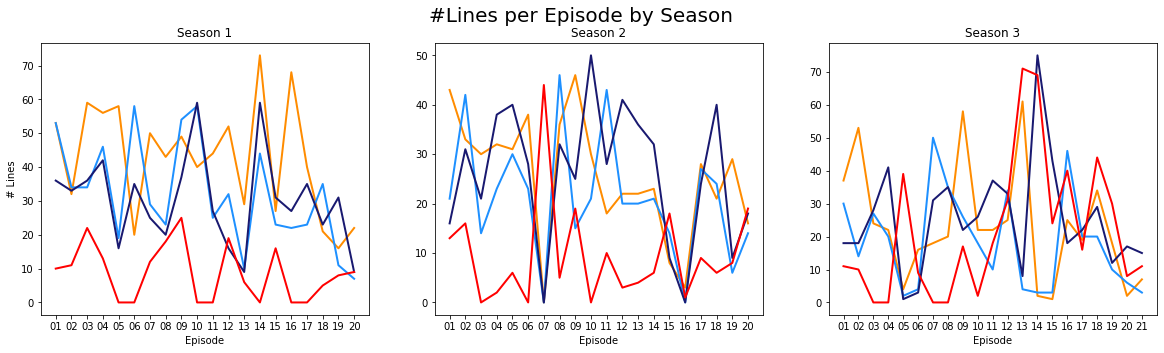

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig.suptitle("#Lines per Episode by Season", fontsize = 20)

seas = 0

for ax in [ax1, ax2, ax3]:
    seas += 1
    for char, col in list(zip("Aang Katara Sokka Zuko".split(" "), "darkorange dodgerblue midnightblue red".split(" "))):
        ax.plot( "Episode", char, data=df[df["Season"]==str(seas)], marker='', color=col, linewidth=2)
        ax.set_title(f"Season {seas}")
        ax.set_xlabel("Episode")

ax1.set_ylabel("# Lines");

#### ...so we'll use a vertical stack instead

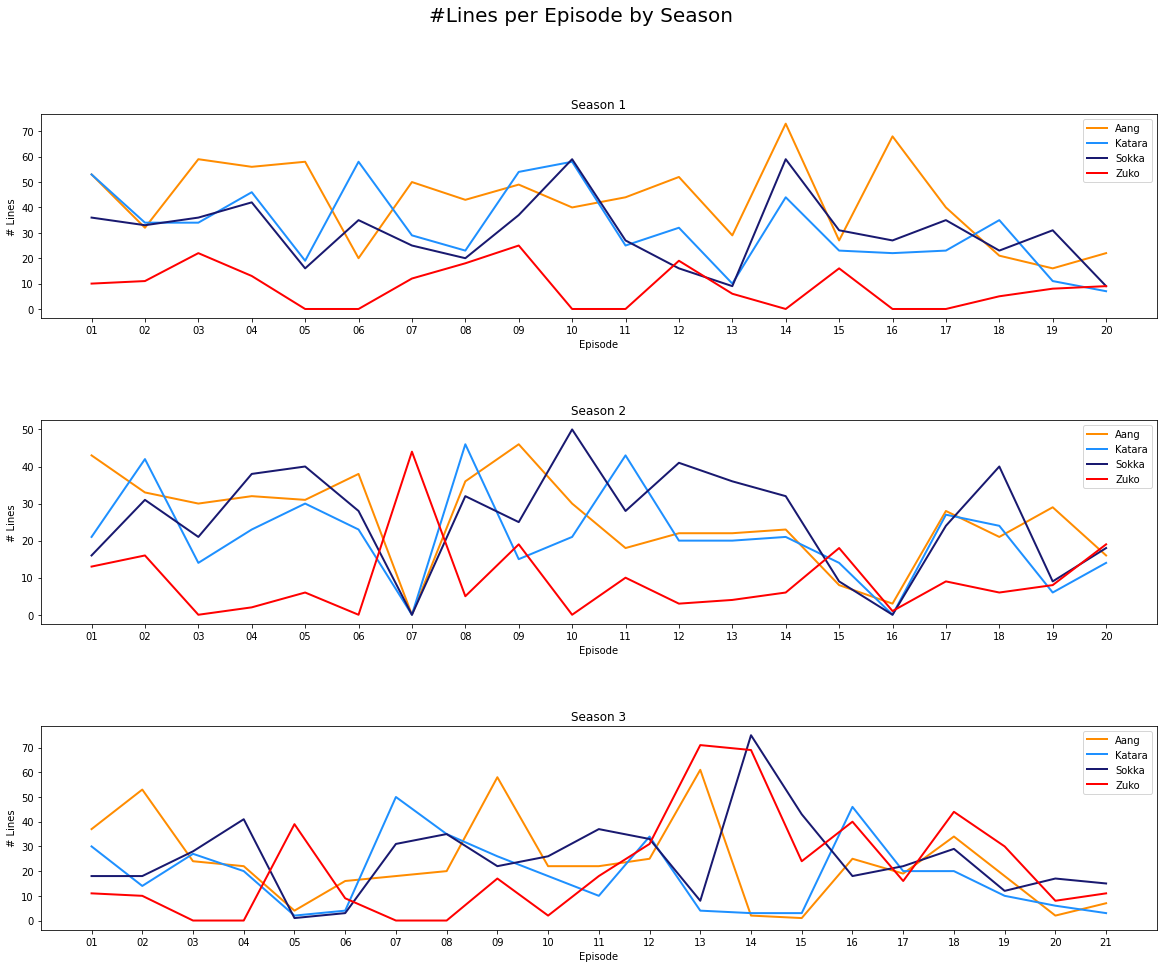

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (20,15))
fig.suptitle("#Lines per Episode by Season", fontsize = 20)

seas = 0

for ax in [ax1, ax2, ax3]:
    seas += 1
    for char, col in list(zip("Aang Katara Sokka Zuko".split(" "), "darkorange dodgerblue midnightblue red".split(" "))):
        ax.plot( "Episode", char, data=df[df["Season"]==str(seas)], marker='', color=col, linewidth=2)
        ax.set_title(f"Season {seas}")
        ax.set_xlabel("Episode")
        ax.set_ylabel("# Lines")
        ax.legend()

fig.subplots_adjust(hspace=0.5);

#### It's cool to see how Zuko normalizes with the rest of the Gaang in season 3!

# Goal 3: Honor Guard

## This is tricky, since if you read the documentation for the original dataset, you'll realize I was quite literally only counting the number of lines of dialogue per character (made easy since I noticed the web pages only bolded the character names when designating line speakers). I'll have to find a new way to track the speaker AND capture the dialogue...

episode_key = "104"
url = f"http://atla.avatarspirit.net/transcripts.php?num={episode_key}"
print(url)
page = requests.get(url)
page_soup = BeautifulSoup(page.content, 'html.parser')

for i in page_soup.find_all():
    if i.name is "b":
        print(i.contents)

In [84]:
#season = episode_key[0]
#ep = episode_key[1:]


atla_ep_data_3 = []
episode_key = "101"
count = 1
gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]



while int(episode_key) < 400:
    season = episode_key[0]
    ep = episode_key[1:]
    #ep_stats = {"Season": season, "Episode": ep}
    ep_dialogue = {}
    ep_dict = {"Season": season, "Episode": ep, "Dialogue": {}}
    add_gaang(ep_dict, nest_value = "Dialogue")

    
    
    url = f"http://atla.avatarspirit.net/transcripts.php?num={episode_key}"
    print(url)
    page = requests.get(url)
    page_soup = BeautifulSoup(page.content, 'html.parser')

    #if len(page_soup.find_all('title', string = "Error :: AvatarSpirit.net") ) > 0:
    if len(page_soup.find_all("div", {"class": "welcome"}, text = "Error")) > 0:
        episode_key = str(int(episode_key) + 101 - int(episode_key[1:]))
        pass
    else:
        add_gaang(ep_dialogue)        
        clean_descriptors(page_soup, destination = ep_dialogue)       

        for character in gaang:
            for line in ep_dialogue[character]:
                if len(line) > 0:
                    ep_dict["Dialogue"][character].append(" ".join(line).split("\r")[0])
                else:
                    pass
                    
        atla_ep_data_3.append(ep_dict)
        
        episode_key = str(int(episode_key)+1)


http://atla.avatarspirit.net/transcripts.php?num=101
http://atla.avatarspirit.net/transcripts.php?num=102
http://atla.avatarspirit.net/transcripts.php?num=103
http://atla.avatarspirit.net/transcripts.php?num=104
http://atla.avatarspirit.net/transcripts.php?num=105
http://atla.avatarspirit.net/transcripts.php?num=106
http://atla.avatarspirit.net/transcripts.php?num=107
http://atla.avatarspirit.net/transcripts.php?num=108
http://atla.avatarspirit.net/transcripts.php?num=109
http://atla.avatarspirit.net/transcripts.php?num=110
http://atla.avatarspirit.net/transcripts.php?num=111
http://atla.avatarspirit.net/transcripts.php?num=112
http://atla.avatarspirit.net/transcripts.php?num=113
http://atla.avatarspirit.net/transcripts.php?num=114
http://atla.avatarspirit.net/transcripts.php?num=115
http://atla.avatarspirit.net/transcripts.php?num=116
http://atla.avatarspirit.net/transcripts.php?num=117
http://atla.avatarspirit.net/transcripts.php?num=118
http://atla.avatarspirit.net/transcripts.php?n

In [85]:
atla_ep_data_3

[{'Season': '1',
  'Episode': '01',
  'Dialogue': {'Aang': ['): I need to ask you something.',
    '): Please... come closer.',
    '): Will you go penguin sledding with me?',
    ": What's going on here?",
    "): I'm not sure.",
    ': Appa! Are you all right? Wake up, buddy.',
    ": Haha! You're okay!",
    ': This is Appa, my flying bison.',
    ": Don't worry. It'll wash out.",
    ': So, do you guys live around here?',
    ": I'm A... aaaahhhh... ahhhhhh.... aaah aaah aaah AAAAAAACHOOOO!",
    ": I'm Aang.   ",
    ': Really? It felt higher that that.',
    ': Sure am.',
    ': Well, if you guys are stuck Appa and I can give you a lift.',
    ': Okay. First time flyers, hold on tight! Appa, yip yip!',
    '): Come on, Appa. Yip yip.',
    ": Appa's just tired. A little rest and he'll be soaring through the sky. You'll see.",
    ': Oh... I was smiling?',
    ": Hey. Whatcha thinkin' about?",
    "): Uhh... no. I didn't know him... I mean, I knew people that knew him, but I didn'

In [93]:
df3 = pd.DataFrame.from_records(atla_ep_data_3)

In [94]:
df3

,Season,Episode,Dialogue
0,1,01,"{'Aang': ['): I need to ask you something.', '..."
1,1,02,"{'Aang': [': Yeh, we were on the ship and ther..."
2,1,03,"{'Aang': [' Wait 'til you see it, Katara. Th..."
3,1,04,"{'Aang': [' Weeelll, I know it's near water...."
4,1,05,{'Aang': [': The Earth Kingdom city of Omashu!...
...,...,...,...
56,3,17,"{'Aang': [': Hey, uh... I wanted to sit ( ) th..."
57,3,18,"{'Aang': [': Ugh! I'm trying.', ': Ooo, ooo, (..."
58,3,19,"{'Aang': [': Where are we, Momo? ( Maybe I'm ..."
59,3,20,"{'Aang': [': Momo, time for you to go.', ': Pl..."


In [98]:
t = pd.DataFrame([i["Dialogue"][char] for i in atla_ep_data_3] for char in gaang).T
t.columns = gaang
t

,Aang,Katara,Sokka,Suki,Toph,Zuko,Mai,Ty Lee,Azula,Iroh
0,"[): I need to ask you something., ): Please......","[): Water... Earth... Fire... Air..., : Sokka,...",[: It's not getting away from me this time. Wa...,[],[],"[: Finally. Uncle, do you realize what this ...",[],[],[],"[: I won't get to finish my game?, : Or it's j..."
1,"[: Yeh, we were on the ship and there was this...",[: Aang didn't do anything. It was an accident...,[): I knew it! You signaled the Fire Navy with...,[],[],"[: Where are you hiding him?, : He'd be about ...",[],[],[],"[: Hey, you mind taking this to his quarters f..."
2,"[ Wait 'til you see it, Katara. The Air Temp...","[ Aang, I know you're excited, but it's been...","[ Sleep now... temple later..., Aaahhh! Get...",[],[],"[ Uncle, I want the repairs made as quickly as...",[],[],[],"[ You mean the Avatar?, <i>Retired</i> gene..."
3,"[ Weeelll, I know it's near water..., Momo,...","[ That's great, Aang., That's great!, Wh...","[ You have no idea where you're going, do you?...","[ And if you don't answer all our questions, w...",[],[ The only reason you should be interrupting...,[],[],[],"[ Well, there is news, Prince Zuko, but you ..."
4,"[: The Earth Kingdom city of Omashu!, : I used...",[: Wow. We don't have cities like this in the ...,[ : They have buildings here that don't melt!...,[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...
56,"[: Hey, uh... I wanted to sit ( ) there. ( ), ...",[: ( ) Doesn't it seem kinda weird that we're ...,[: ( ) You guys are not going to believe this....,[: ( ) We were just in town and we found this ...,[: ( ) Why are we sitting in the nose bleed se...,"[: ( ) I told you, my Father hasn't come here ...",[],[],[],[]
57,"[: Ugh! I'm trying., : Ooo, ooo, ( ) me, me, m...","[: Who wants a nice, cool glass of watermelon ...",[: ( ) Maybe Zuko's right. ( .) Sitting around...,"[ I think it's sweet. ( ), ) But he looked so ...","[: Not bad, baldy. But I've been working on my...","[: More ferocious! , : Imagine striking throug...",[],[],[: ( ) I think you should take their precious ...,[]
58,"[: Where are we, Momo? ( Maybe I'm in the Spi...","[: I'm not his girlfriend!, : I have Aang's st...","[: Hey, I remember her. She helped you attack ...","[: So wait, how do you all know each other? , ...","[: We know he's gone, that's why we're trying ...","[: Yup, back in the good old days. ( , : He's...",[],[],[],[: I was never angry with you. I was sad ( ) b...
59,"[: Momo, time for you to go., : Please listen ...","[: Zuko, don't worry, we can take Azula., : Aa...",[: We're too late! The fleet's already taking ...,"[: It's weird to say, but the comet actually l...",[: Too bad the Fire Lord is about to use it to...,"[: I'm not worried about her, I'm worried abou...",[],[],"[: What am I holding?, : Correct. And what d...",[: Only once every hundred years can a fireben...


In [99]:
lines.Aang

0     [): I need to ask you something., ): Please......
1     [: Yeh, we were on the ship and there was this...
2     [   Wait 'til you see it, Katara. The Air Temp...
3     [   Weeelll, I know it's near water...,  Momo,...
4     [: The Earth Kingdom city of Omashu!, : I used...
                            ...                        
56    [: Hey, uh... I wanted to sit ( ) there. ( ), ...
57    [: Ugh! I'm trying., : Ooo, ooo, ( ) me, me, m...
58    [: Where are we, Momo? (  Maybe I'm in the Spi...
59    [: Momo, time for you to go., : Please listen ...
60    [: ( ) Fire Lord Ozai, you and your forefather...
Name: Aang, Length: 61, dtype: object

In [100]:
t.Aang

0     [): I need to ask you something., ): Please......
1     [: Yeh, we were on the ship and there was this...
2     [   Wait 'til you see it, Katara. The Air Temp...
3     [   Weeelll, I know it's near water...,  Momo,...
4     [: The Earth Kingdom city of Omashu!, : I used...
                            ...                        
56    [: Hey, uh... I wanted to sit ( ) there. ( ), ...
57    [: Ugh! I'm trying., : Ooo, ooo, ( ) me, me, m...
58    [: Where are we, Momo? (  Maybe I'm in the Spi...
59    [: Momo, time for you to go., : Please listen ...
60    [: ( ) Fire Lord Ozai, you and your forefather...
Name: Aang, Length: 61, dtype: object

In [101]:
lines.Aang == t.Aang

0     True
1     True
2     True
3     True
4     True
      ... 
56    True
57    True
58    True
59    True
60    True
Name: Aang, Length: 61, dtype: bool

In [10]:
#season = episode_key[0]
#ep = episode_key[1:]


atla_ep_data_2 = []
episode_key = "101"
count = 1
gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]



while int(episode_key) < 400:
    season = episode_key[0]
    ep = episode_key[1:]
    #ep_stats = {"Season": season, "Episode": ep}
    ep_dialogue = {}
    ep_dict = {"Season": season, "Episode": ep}
    add_gaang(ep_dict)
    
    url = f"http://atla.avatarspirit.net/transcripts.php?num={episode_key}"
    #print(url)
    page = requests.get(url)
    page_soup = BeautifulSoup(page.content, 'html.parser')

    #if len(page_soup.find_all('title', string = "Error :: AvatarSpirit.net") ) > 0:
    if len(page_soup.find_all("div", {"class": "welcome"}, text = "Error")) > 0:
        episode_key = str(int(episode_key) + 101 - int(episode_key[1:]))
        pass
    else:
        
        add_gaang(ep_dialogue)
        clean_descriptors(page_soup, destination = ep_dialogue)

        for character in gaang:
            for line in ep_dialogue[character]:
                if len(line) > 0:
                    ep_dict[character].append(" ".join(line).split("\r")[0])
                    
        atla_ep_data_2.append(ep_dict)
        
        episode_key = str(int(episode_key)+1)


In [14]:
#[[i, j] + d[i][j] for i in d for j in d[i]]
[atla_ep_data + atla_ep_data[i] for i in atla_ep_data]


TypeError: list indices must be integers or slices, not dict

In [11]:
lines = pd.DataFrame(atla_ep_data_2)

In [13]:
lines.head(3)

,Season,Episode,Aang,Katara,Sokka,Suki,Toph,Zuko,Mai,Ty Lee,Azula,Iroh
0,1,01,"[): I need to ask you something., ): Please......","[): Water... Earth... Fire... Air..., : Sokka,...",[: It's not getting away from me this time. Wa...,[],[],"[: Finally. Uncle, do you realize what this ...",[],[],[],"[: I won't get to finish my game?, : Or it's j..."
1,1,02,"[: Yeh, we were on the ship and there was this...",[: Aang didn't do anything. It was an accident...,[): I knew it! You signaled the Fire Navy with...,[],[],"[: Where are you hiding him?, : He'd be about ...",[],[],[],"[: Hey, you mind taking this to his quarters f..."
2,1,03,"[ Wait 'til you see it, Katara. The Air Temp...","[ Aang, I know you're excited, but it's been...","[ Sleep now... temple later..., Aaahhh! Get...",[],[],"[ Uncle, I want the repairs made as quickly as...",[],[],[],"[ You mean the Avatar?, <i>Retired</i> gene..."


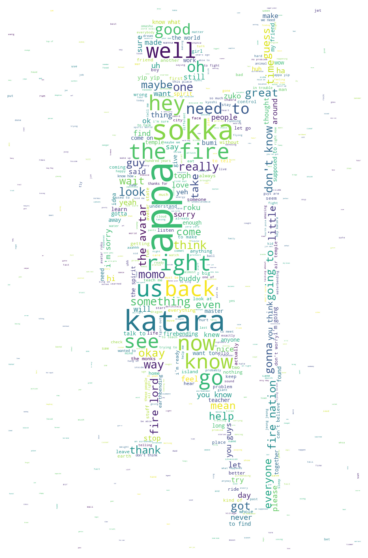

In [23]:
ep_words = []

for ep in range(len(lines.Aang)):
    ep_words.append(" ".join([items for items in lines.Aang[ep]]))

#############################################

all_aang_words_raw = " ".join(ep_words)
aang_cleaned_words_2 = all_aang_words_raw.replace("<i>", "")
aang_cleaned_words_2 = aang_cleaned_words_2.replace("</i>", "")
aang_string = re.sub(" +", " ", re.sub(r"[^\w']", ' ', aang_cleaned_words_2.lower()))

#############################################

stopwords = set(STOPWORDS)
aang_mask = np.array(Image.open("Aang image.jpg"))
wc = WordCloud(stopwords=stopwords, mask = aang_mask, background_color="white", mode="RGBA", max_words=1000).generate(aang_string.lower())
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.to_file("Aang wordcloud.png")

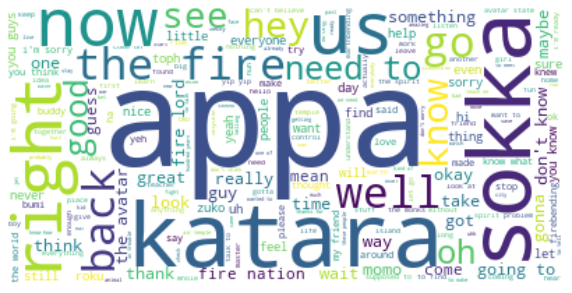

#gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]


season = episode_key[0]
ep = episode_key[1:]
ep_dialogue = {"Season": season, "Episode": ep}
ep_dict = {"Season": season, "Episode": ep}


"""
ep_dialogue = {x: [] for x in gaang}
ep_dict = {x: [] for x in gaang}"""

for character in gaang:
    ep_dialogue[character] = []
    ep_dict[character] = []
    
for i in page_soup.body.find_all('b'):
    if i.text in gaang.keys() or i.text[:-1] in gaang.keys():
        if i.text[-1] == ":":
            key = i.text[:-1]
        else:
            key = i.text

            
        x = []
        
        
        for j in i.next_siblings:
            if j.name == "b":
                break
            #elif j.name == "i": Removes Italics; issues is emphasized words are italicized
            #    pass
            elif j.string == None:
                pass
            elif j.name == 'i' and j.string[0] == "(":
                pass
            else:
                x.append(str(j)) ## here vs later loop for <i> vs  [] 
        ep_dialogue[key].append(x)
        pass

for character in ep_dict.keys():
    for line in ep_dialogue[character]:
        if len(line) > 0:
            ep_dict[character].append(" ".join(line))
        else:
            ep_dict[character].append(line)

ep_dict

print (len(ep_dialogue["Zuko"]))

df2

df2.to_excel("103_Aang.xls")